#### 定量的マクロ経済学と数値計算 第3章 動的計画法
➁無限期間モデルの解法(状態変数と操作変数を離散化): メインファイル

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from CRRA import CRRA, mu_CRRA

In [2]:
#STEP 1(a): カリブレーション & グリッド生成
class Model():
    """
    モデルを解くためのパラメータを含む class を定義する。
    """
    def __init__(self,
        beta = 0.96,  # 割引因子
        gamma = 1.0,  # 異時点間の代替弾力性の逆数
        alpha = 0.4,  # 資本分配率 
        delta = 1.0,  # 固定資本減耗
        nk = 10001,   # 資本のグリッド数
        kmax = 0.5,   # 資本グリッドの最大値
        kmin = 0.05,  # 資本グリッドの最小値
        maxit = 1000, # 繰り返し計算の最大値
        tol = 1e-5,   # 許容誤差(STEP 4)
        ): 
        
        self.beta, self.gamma, self.alpha = beta, gamma, alpha 
        self.delta, self.nk = delta, nk 
        self.kmax, self.kmin = kmax, kmin 
        self.maxit, self.tol = maxit, tol
        self.kgrid = np.linspace(kmin,kmax,nk) # 資本のグリッド




#収束に関するパラメータ
it = 1 #ループカウンター
dif1 = 1.0 #価値関数の繰り返し誤差
dif2 = 1.0 #政策関数の繰り返し誤差

#STEP 1(b): 価値関数・政策関数の初期値を設定
m = Model()
vfcn = np.ones(m.nk)
pfcn = np.ones_like(vfcn)
Tvfcn = np.zeros_like(vfcn)
Tpfcn = np.zeros_like(vfcn)
vkp = np.empty((m.nk,m.nk))
v_conv = [] #価値関数の繰り返し誤差を記録していく。各繰り返しごとにリストに追加していく。
p_conv = [] #政策関数の繰り返し誤差を記録していく。

In [3]:
#STEP 2: 効用関数の組み合わせ

#効用関数の初期値(消費が0以下になる組み合わせにはペナルティ)
#MATLABコード上はループで明示的にペナルティを与えているが、pythonコードではCRRA関数において先に負の消費にペナルティを与えている。
util = np.ones((m.nk,m.nk))

#(k,k')の組み合わせについて効用を計算
for i in range(m.nk): #今期の資本量
    for j in range(m.nk): #来期の資本量
        
        wealth = m.kgrid[i] ** m.alpha + (1.0-m.delta)*m.kgrid[i]
        cons = wealth - m.kgrid[j]
        util[i,j] = CRRA(m,cons) #MATLABは[j,i]の順

#STEP 3: 価値関数を繰り返し計算

while (it<m.maxit) & (dif1>m.tol):

    #ベルマン方程式: V(k;k')
    for i in range(m.nk):
        
        vkp[i,:] = util[i,:] + m.beta*vfcn
        
        #最適化: 各kについてV(k,k')を最大にするk'を探す
        ploc = np.argmax(vkp[i,:])
        Tvfcn[i] = vkp[i,ploc]
        Tpfcn[i] = m.kgrid[ploc]
    
    #繰り返し誤差を確認
    dif1 = np.max(np.abs((Tvfcn-vfcn)/vfcn))
    dif2 = np.max(np.abs((Tpfcn-pfcn)/pfcn)) 
    
    #価値関数・政策関数をアップデート
    vfcn = np.copy(Tvfcn)
    pfcn = np.copy(Tpfcn)

    print(f"iteration index: {it}, iteration diff of value: {dif1:.7f}")

    #収束途中の繰り返し計算誤差を保存
    v_conv.append(dif1)
    p_conv.append(dif2)

    it += 1

iteration index: 1, iteration diff of value: 1.4194823
iteration index: 2, iteration diff of value: 38049.0146748
iteration index: 3, iteration diff of value: 2.7947604
iteration index: 4, iteration diff of value: 0.7270939
iteration index: 5, iteration diff of value: 0.4082642
iteration index: 6, iteration diff of value: 0.2793964
iteration index: 7, iteration diff of value: 0.2099685
iteration index: 8, iteration diff of value: 0.1666927
iteration index: 9, iteration diff of value: 0.1371947
iteration index: 10, iteration diff of value: 0.1158286
iteration index: 11, iteration diff of value: 0.0996567
iteration index: 12, iteration diff of value: 0.0870016
iteration index: 13, iteration diff of value: 0.0768371
iteration index: 14, iteration diff of value: 0.0685005
iteration index: 15, iteration diff of value: 0.0615447
iteration index: 16, iteration diff of value: 0.0556575
iteration index: 17, iteration diff of value: 0.0506141
iteration index: 18, iteration diff of value: 0.04624

In [4]:
#計算結果を表示
print("-+- PARAMETER VALUES -+-")
print(f"beta={m.beta}, gamma={m.gamma}, alpha={m.alpha}, delta={m.delta}")
print(f"kmin={m.kmin}, kmax={m.kmax}, grid={m.nk}")

-+- PARAMETER VALUES -+-
beta=0.96, gamma=1.0, alpha=0.4, delta=1.0
kmin=0.05, kmax=0.5, grid=10001


In [5]:
#解析的解
AA = (1-m.beta)**(-1) * (np.log(1-m.alpha*m.beta) + ((m.alpha*m.beta)/(1-m.alpha*m.beta))*np.log(m.alpha*m.beta))
BB = m.alpha/(1-m.alpha*m.beta)
v_true = AA + BB*np.log(m.kgrid)
p_true = m.beta * m.alpha * (m.kgrid ** m.alpha)

#### 図を描く

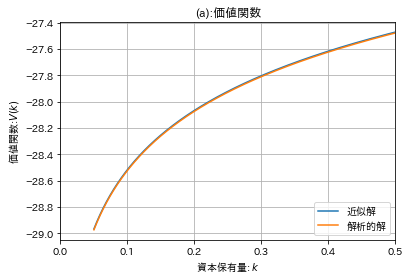

In [6]:
fig, ax = plt.subplots()
ax.plot(m.kgrid,vfcn,label="近似解")
ax.plot(m.kgrid,v_true,label="解析的解")
ax.set(title="(a):価値関数",xlabel=r"資本保有量: $k$", ylabel=r"価値関数:$V(k)$",xlim=(0,m.kmax))
ax.legend(loc="lower right")
ax.grid()
plt.show()

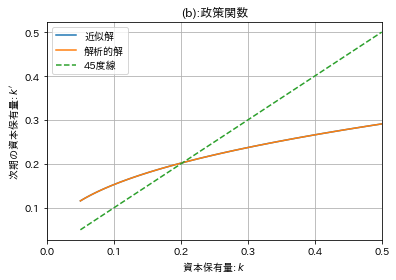

In [7]:
fig, ax = plt.subplots()
ax.plot(m.kgrid, pfcn, label="近似解")
ax.plot(m.kgrid, p_true, label="解析的解")
ax.plot(m.kgrid, m.kgrid, ls="--", label="45度線")
ax.set(title="(b):政策関数",xlabel=r"資本保有量: $k$", ylabel=r"次期の資本保有量: $k'$",xlim=(0,m.kmax))
ax.legend(loc="upper left")
ax.grid()
plt.show()

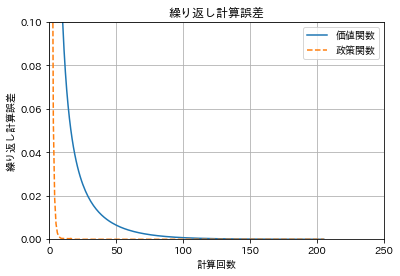

In [8]:
fig, ax = plt.subplots()
ax.plot(v_conv,label="価値関数")
ax.plot(p_conv,label="政策関数",ls="--")
ax.set(xlabel="計算回数", ylabel="繰り返し計算誤差", title="繰り返し計算誤差",xlim=(0,250),ylim=(0,0.1))
ax.grid()
ax.legend(loc="upper right")
plt.show()